In [84]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import re
import numpy as np
from skimage.metrics import structural_similarity as ssim
import cv2

# grab folder names starting with 'DHR' in folder 'output'
# get all folders in 'output'
folders = os.listdir('output/plot_combine_results')

# filter folders starting with 'DHR'
folders = [f for f in folders if re.match(r'^DHR', f)]
folders.sort()
# print(folders)
print(len(folders))

# create output folder
os.makedirs('output/plot_combine_results/combined', exist_ok=True)

9


In [85]:
# mse
def mse(img1, img2):
    err = np.sum((img1.astype('float') - img2.astype('float')) ** 2)
    err /= float(img1.shape[0] * img1.shape[1])
    return err

# ssim
def ssim_score(img1, img2):
    return ssim(img1, img2, data_range=img2.max() - img2.min())

def blend_img(edge, image):
    """
    Overlaying edges (contour) onto an image.
    :param color:
    :param edge: edges of fixed image
    :param image: moving/warped image
    :return: output image
    """

    edge_color = np.array((0, 255, 0)) / 255.  # now 0 = dark, 255 = light
    # if the image is float, convert to uint8
    if image.dtype == np.float32:
        image = np.uint8(image * 255)
    out = np.zeros((image.shape[0], image.shape[1], 3))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if edge[i, j] > 127:
                opacity = 0.25
                out[i, j] = edge_color * opacity + np.array(image[i, j]) * (1 - opacity)/255.
            else:
                out[i, j] = np.array((image[i, j], image[i, j], image[i, j])) / 255.

    # convert image to float
    # out = np.float32(out)
    return out

In [86]:
src_folder = 'output/plot_combine_results/DHR2x_60100_0.0001_0_2_1_20240606-183830_test'

# grab filenames ending with 'source.png' in folder 'DHR2x_60100_0.0001_0_2_1_20240606-183830_test'
files = os.listdir('output/plot_combine_results/DHR2x_60100_0.0001_0_2_1_20240606-183830_test')
source = [os.path.join(src_folder, f) for f in files if re.match(r'.*source.png$', f)]

# sort files by name
source.sort()
print(source[0])

output/plot_combine_results/DHR2x_60100_0.0001_0_2_1_20240606-183830_test/test_0_1_source.png


In [87]:
# grab filenames ending with 'target.png' in folder 'DHR2x_60100_0.0001_0_2_1_20240606-183830_test'
target = [os.path.join(src_folder, f) for f in files if re.match(r'.*target.png$', f)]

# sort files by name
target.sort()
print(target[0])

output/plot_combine_results/DHR2x_60100_0.0001_0_2_1_20240606-183830_test/test_0_1_target.png


In [88]:
# loop through all folders and grab filenames ending with 'warped.png', store in 2D list
warped = []
for folder in folders:
    files = os.listdir('output/plot_combine_results/' + folder)
    warped.append([f"output/plot_combine_results/{folder}/{f}" for f in files if re.match(r'.*warped.png$', f)])

# sort files by name
for w in warped:
    w.sort()
# print(warped)
print(len(warped))
for i, w in enumerate(folders):
    print(i+1, w)

9
1 DHR2x_60100_0.0001_0_2_1_20240606-183830_test
2 DHR2x_60100_0.001_0_1_1_20240606-185322_rep1_test
3 DHR2x_60100_0.001_0_1_1_20240606-193523_ensemble_1way_reverse_test
4 DHRdiff_60100_0.0001_0_2_1_20240606-190051_test
5 DHRdiff_60100_0.001_0_1_1_20240606-190100_rep1_test
6 DHRdiff_60100_0.001_0_1_1_20240606-192408_ensemble_1way_reverse_test
7 DHRoriginal_60100_0.0001_0_2_1_20240606-185936_test
8 DHRoriginal_60100_0.001_0_1_1_20240606-185945_rep1_test
9 DHRoriginal_60100_0.001_0_1_1_20240606-191123_ensemble_1way_reverse_test


In [89]:
titles = ['DHR2x no repeat', 'DHR2x repeat fw', 'DHR2x ensemble rep fw+rv',
          'DHRdiff no repeat', 'DHRdiff repeat fw', 'DHRdiff ensemble rep fw+rv',
          'DHR no repeat', 'DHR repeat fw', 'DHR ensemble rep fw+rv']

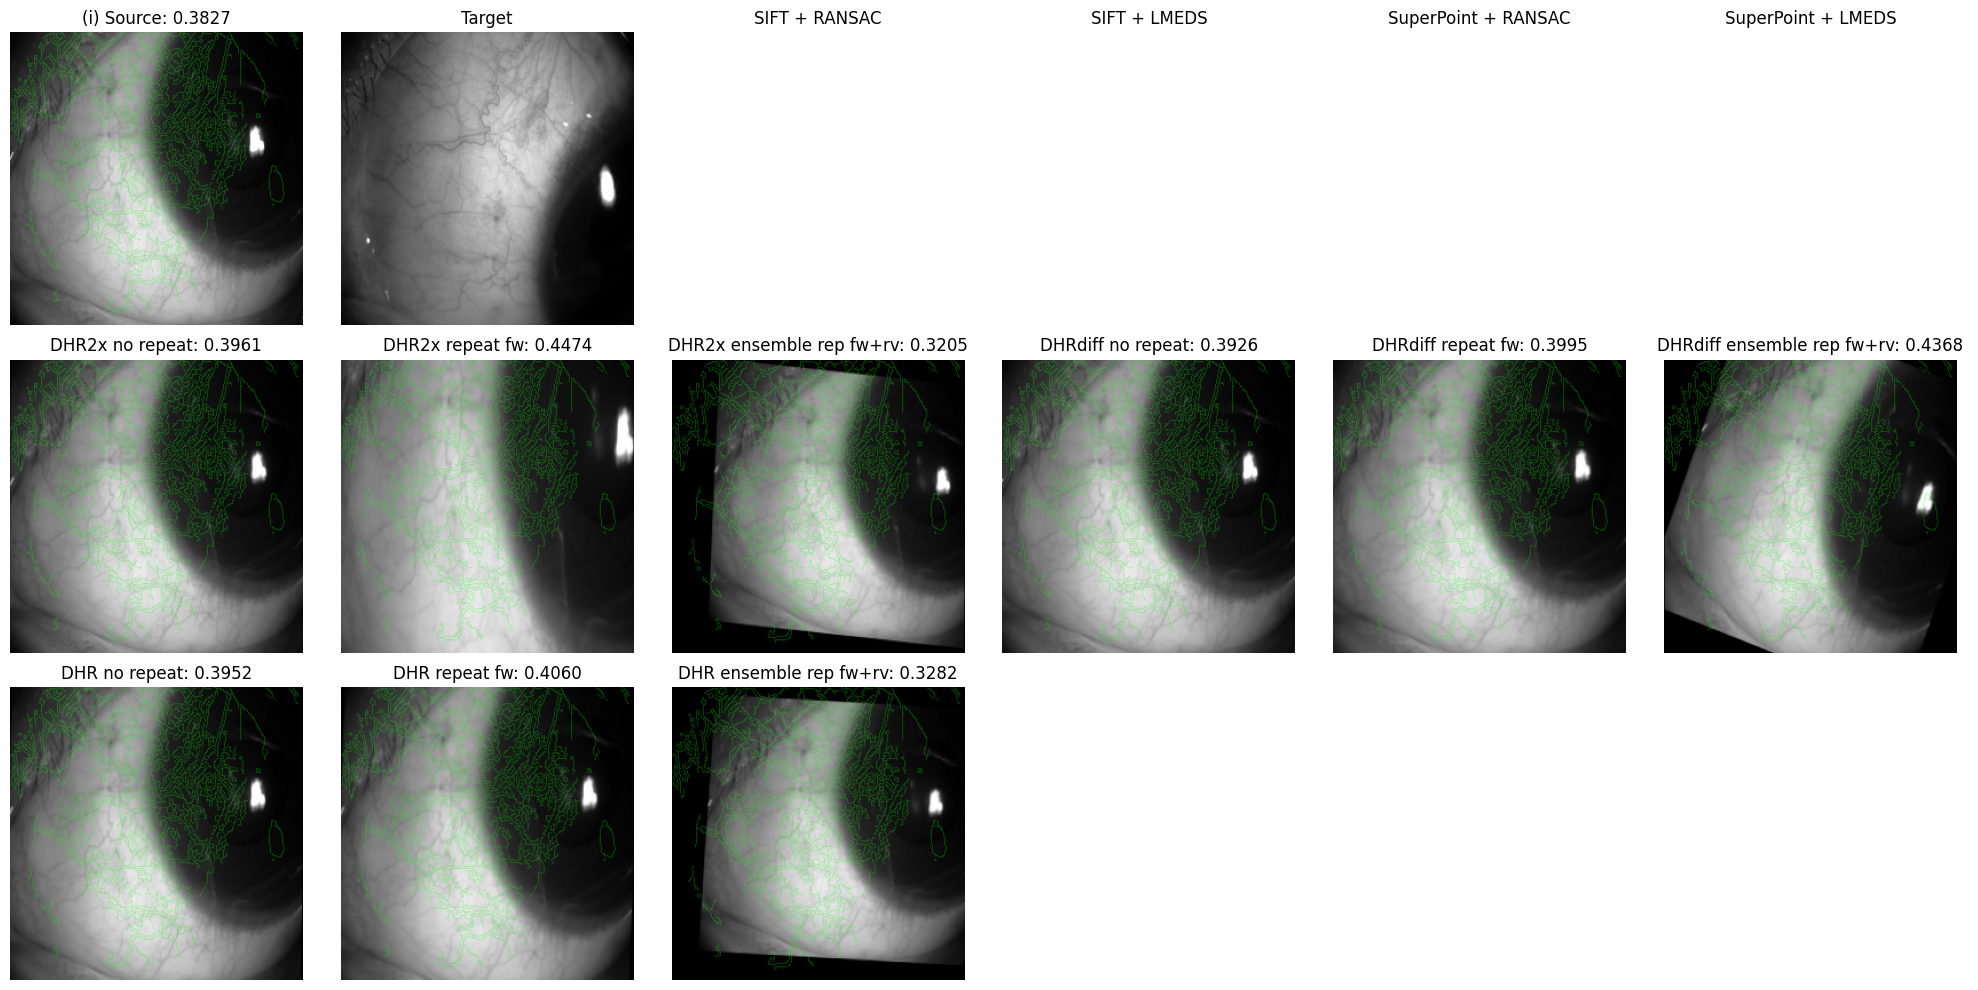

In [90]:
# create 3x6 grid of images
fig, axes = plt.subplot_mosaic("ABCDEF;GHIJKL;MNOPQR", figsize=(20, 10))

source_img = mpimg.imread(source[0])
target_img = mpimg.imread(target[0])
edges = cv2.Canny((target_img*255).astype(np.uint8), 100, 20)

axes["A"].imshow(blend_img(edges, source_img))
axes["A"].set_title(f"(i) Source: {ssim_score(source_img, target_img):.4f}")

axes["B"].imshow(target_img, cmap='gray')
axes["B"].set_title(f"Target")

axes["C"].set_title("SIFT + RANSAC")
axes["D"].set_title("SIFT + LMEDS")
axes["E"].set_title("SuperPoint + RANSAC")
axes["F"].set_title("SuperPoint + LMEDS")


for i in range(6):
    img = mpimg.imread(warped[i][0])
    axes["GHIJKL"[i]].imshow(blend_img(edges, img))
    axes["GHIJKL"[i]].set_title(f"{titles[i]}: {ssim_score(img, target_img):.4f}")

for i in range(6, 9):
    img = mpimg.imread(warped[i][0])
    axes["MNOPQR"[i-6]].imshow(blend_img(edges, img))
    axes["MNOPQR"[i-6]].set_title(f"{titles[i]}: {ssim_score(img, target_img):.4f}")

# hide all axes
for ax in axes.values():
    ax.axis("off")

plt.tight_layout()
plt.show()


In [91]:
# automate for all images
for i in range(len(source)):
    fig, axes = plt.subplot_mosaic("ABCDEF;GHIJKL;MNOPQR", figsize=(20, 10))

    source_img = mpimg.imread(source[i])
    target_img = mpimg.imread(target[i])
    edges = cv2.Canny((target_img*255).astype(np.uint8), 100, 20)

    axes["A"].imshow(blend_img(edges, source_img))
    axes["A"].set_title(f"({i+1}) Source: {ssim_score(source_img, target_img):.4f}")

    axes["B"].imshow(target_img, cmap='gray')
    axes["B"].set_title(f"Target")

    axes["C"].set_title("SIFT + RANSAC")
    axes["D"].set_title("SIFT + LMEDS")
    axes["E"].set_title("SuperPoint + RANSAC")
    axes["F"].set_title("SuperPoint + LMEDS")

    for j in range(6):
        img = mpimg.imread(warped[j][i])
        axes["GHIJKL"[j]].imshow(blend_img(edges, img))
        axes["GHIJKL"[j]].set_title(f"{titles[j]}: {ssim_score(img, target_img):.4f}")

    for j in range(6, 9):
        img = mpimg.imread(warped[j][i])
        axes["MNOPQR"[j-6]].imshow(blend_img(edges, img))
        axes["MNOPQR"[j-6]].set_title(f"{titles[j]}: {ssim_score(img, target_img):.4f}")
        
    # hide all axes
    for ax in axes.values():
        ax.axis("off")

    plt.tight_layout()
    # name as 3 digit number
    plt.savefig(f'output/plot_combine_results/combined/{i+1:03d}.png')
    plt.close()